#  BPSK Demodulation in Nonlinear Channels with Deep Neural Networks

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates:
* demodulation of BPSK symbols in highly nonlinear channels using an artificial neural network, implemented via PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets
%matplotlib inline 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


Specify the parameters of the transmission as the fiber length $L$ (in km), the fiber nonlinearity coefficienty $\gamma$ (given in 1/W/km) and the total noise power $P_n$ (given in dBM. The noise is due to amplified spontaneous emission in amplifiers along the link). We assume a model of a dispersion-less fiber affected by nonlinearity. The model, which is described for instance in [1] is given by an iterative application of the equation
$$
x_{k+1} = x_k\exp\left(\jmath\frac{L}{K}\gamma|x_k|^2\right) + n_{k+1},\qquad 0 \leq k < K
$$
where $x_0$ is the channel input (the modulated, complex symbols) and $x_K$ is the channel output. $K$ denotes the number of steps taken to simulate the channel Usually $K=50$ gives a good approximation.

[1] S. Li, C. Häger, N. Garcia, and H. Wymeersch, "Achievable Information Rates for Nonlinear Fiber Communication via End-to-end Autoencoder Learning," Proc. ECOC, Rome, Sep. 2018

In [25]:
# Length of transmission (in km)
L = 5000

# fiber nonlinearity coefficient
gamma = 1.27

Pn = -21.3 # noise power (in dBm)

Kstep = 50 # number of steps used in the channel model

def simulate_channel(x, Pin):  
    # modulate bpsk
    input_power_linear = 10**((Pin-30)/10)
    norm_factor = np.sqrt(input_power_linear);
    bpsk = (1 - 2*x) * norm_factor

    # noise variance per step    
    sigma = np.sqrt((10**((Pn-30)/10)) / Kstep / 2)    

    temp = np.array(bpsk, copy=True)
    for i in range(Kstep):
        power = np.absolute(temp)**2
        rotcoff = (L / Kstep) * gamma * power
        temp = temp * np.exp(1j*rotcoff) + sigma*(np.random.randn(len(x)) + 1j*np.random.randn(len(x)))
    return temp

We consider BPSK transmission over this channel.

Show constellation as a function of the fiber input power. When the input power is small, the effect of the nonlinearity is small (as $\jmath\frac{L}{K}\gamma|x_k|^2 \approx 0$) and the transmission is dominated by the additive noise. If the input power becomes larger, the effect of the noise (the noise power is constant) becomes less pronounced, but the constellation rotates due to the larger input power and hence effect of the nonlinearity.

In [26]:
length = 5000

def plot_constellation(Pin):
    t = np.random.randint(2,size=length)
    r = simulate_channel(t, Pin)

    plt.figure(figsize=(6,6))
    font = {'size'   : 14}
    plt.rc('font', **font)
    plt.rc('text', usetex=matplotlib.checkdep_usetex(True))
    plt.scatter(np.real(r), np.imag(r), c=t, cmap='coolwarm')
    plt.xlabel(r'$\Re\{r\}$',fontsize=14)
    plt.ylabel(r'$\Im\{r\}$',fontsize=14)
    plt.axis('equal')
    plt.title('Received constellation (L = %d km, $P_{in} = %1.2f$\,dBm)' % (L, Pin))    
    #plt.savefig('bpsk_received_zd_%1.2f.pdf' % Pin,bbox_inches='tight')
    
interactive_update = interactive(plot_constellation, Pin = widgets.FloatSlider(min=-10.0,max=10.0,step=0.1,value=1, continuous_update=False, description='Input Power Pin (dBm)', style={'description_width': 'initial'}, layout=widgets.Layout(width='50%')))


output = interactive_update.children[-1]
output.layout.height = '500px'
interactive_update

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Input Power Pin (dBm)', lay…

Helper function to plot the constellation together with the decision region. Note that a bit is decided as "1" if $\sigma(\boldsymbol{\theta}^\mathrm{T}\boldsymbol{r}) > \frac12$, i.e., if $\boldsymbol{\theta}^\mathrm{T}\boldsymbol{r}$ > 0. The decision line is therefore given by $\theta_1\Re\{r\} + \theta_2\Im\{r\} = 0$, i.e., $\Im\{r\} = -\frac{\theta_1}{\theta_2}\Re\{r\}$

Generate training, validation and testing data sets

In [4]:
# helper function to compute the bit error rate
def BER(predictions, labels):
    decision = predictions >= 0.5
    temp = decision != (labels != 0)
    return np.mean(temp)

In [5]:
# set input power
Pin = 3

# validation set. Training examples are generated on the fly
N_valid = 100000


hidden_neurons_1 = 8
hidden_neurons_2 = 14


y_valid = np.random.randint(2,size=N_valid)
r = simulate_channel(y_valid, Pin)

# find extension of data (for normalization and plotting)
ext_x = max(abs(np.real(r)))
ext_y = max(abs(np.imag(r)))
ext_max = max(ext_x,ext_y)*1.2

# scale data to be between 0 and 1
X_valid = torch.from_numpy(np.column_stack((np.real(r), np.imag(r))) / ext_max).float().to(device)


# meshgrid for plotting
mgx,mgy = np.meshgrid(np.linspace(-ext_max,ext_max,200), np.linspace(-ext_max,ext_max,200))
meshgrid = torch.from_numpy(np.column_stack((np.reshape(mgx,(-1,1)),np.reshape(mgy,(-1,1)))) / ext_max).float().to(device)

In [7]:
class Receiver_Network(nn.Module):
    def __init__(self, hidden1_neurons, hidden2_neurons):
        super(Receiver_Network, self).__init__()
        # Linear function, 2 input neurons (real and imaginary part)        
        self.fc1 = nn.Linear(2, hidden1_neurons) 

        # Non-linearity
        self.activation_function = nn.ELU()
       
        # Linear function (hidden layer)
        self.fc2 = nn.Linear(hidden1_neurons, hidden2_neurons)  
        
        # Output function 
        self.fc3 = nn.Linear(hidden2_neurons, 1)
        

    def forward(self, x):
        # Linear function, first layer
        out = self.fc1(x)

        # Non-linearity, first layer
        out = self.activation_function(out)
        
        # Linear function, second layer
        out = self.fc2(out)
        
        # Non-linearity, second layer
        out = self.activation_function(out)
        
        # Linear function, third layer
        out = self.fc3(out)
              
        return out

In [29]:
model = Receiver_Network(hidden_neurons_1, hidden_neurons_2)
model.to(device)

sigmoid = nn.Sigmoid()


# channel parameters
norm_factor = np.sqrt(10**((Pin-30)/10));
sigma = np.sqrt((10**((Pn-30)/10)) / Kstep / 2)

# Binary Cross Entropy loss
loss_fn = nn.BCEWithLogitsLoss()

# Adam Optimizer
optimizer = optim.Adam(model.parameters())  


# Training parameters
num_epochs = 160
batches_per_epoch = 300

# Vary batch size during training
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs)


validation_BERs = np.zeros(num_epochs)
decision_region_evolution = []

for epoch in range(num_epochs):
    batch_labels = torch.empty(int(batch_size_per_epoch[epoch]), device=device)
    noise = torch.empty((int(batch_size_per_epoch[epoch]),2), device=device, requires_grad=False)        

    for step in range(batches_per_epoch):
        # sample new mini-batch directory on the GPU (if available)        
        batch_labels.random_(2)
        # channel simulation directly on the GPU
        bpsk = ((1 - 2*batch_labels) * norm_factor).unsqueeze(-1) * torch.tensor([1.0,0.0],device=device)

        for i in range(Kstep):
            power = torch.norm(bpsk, dim=1) ** 2
            rotcoff = (L / Kstep) * gamma * power
            noise.normal_(mean=0, std=sigma) # sample noise
            
            # phase rotation due to nonlinearity
            temp1 = bpsk[:,0] * torch.cos(rotcoff) - bpsk[:,1] * torch.sin(rotcoff)            
            temp2 = bpsk[:,0] * torch.sin(rotcoff) + bpsk[:,1] * torch.cos(rotcoff)            
            bpsk = torch.stack([temp1, temp2], dim=1) + noise

        bpsk = bpsk / ext_max
        outputs = model(bpsk)

        # compute loss
        loss = loss_fn(outputs.squeeze(), batch_labels)
        
        # compute gradients
        loss.backward()
        
        optimizer.step()
        # reset gradients
        optimizer.zero_grad()
        
    # compute validation BER
    out_valid = sigmoid(model(X_valid))
    validation_BERs[epoch] = BER(out_valid.detach().cpu().numpy().squeeze(), y_valid)
    
    print('Validation BER after epoch %d: %f (loss %1.8f)' % (epoch, validation_BERs[epoch], loss.detach().cpu().numpy()))                
        
    # store decision region for generating the animation
    mesh_prediction = sigmoid(model(meshgrid))    
    decision_region_evolution.append(0.195*mesh_prediction.detach().cpu().numpy() + 0.4)


Validation BER after epoch 0: 0.011900 (loss 0.04081550)
Validation BER after epoch 1: 0.011880 (loss 0.06237675)
Validation BER after epoch 2: 0.011880 (loss 0.05860055)
Validation BER after epoch 3: 0.011930 (loss 0.03137892)
Validation BER after epoch 4: 0.011840 (loss 0.02328396)
Validation BER after epoch 5: 0.011940 (loss 0.01498417)
Validation BER after epoch 6: 0.011830 (loss 0.03882520)
Validation BER after epoch 7: 0.011960 (loss 0.03213685)
Validation BER after epoch 8: 0.011820 (loss 0.03174237)
Validation BER after epoch 9: 0.011920 (loss 0.02231092)
Validation BER after epoch 10: 0.011950 (loss 0.02508574)
Validation BER after epoch 11: 0.011820 (loss 0.03134822)
Validation BER after epoch 12: 0.011750 (loss 0.03832325)
Validation BER after epoch 13: 0.011900 (loss 0.02572788)
Validation BER after epoch 14: 0.011720 (loss 0.04637164)
Validation BER after epoch 15: 0.011770 (loss 0.02873223)
Validation BER after epoch 16: 0.011630 (loss 0.03887529)
Validation BER after epo

Validation BER after epoch 141: 0.000020 (loss 0.00001830)
Validation BER after epoch 142: 0.000020 (loss 0.00000928)
Validation BER after epoch 143: 0.000020 (loss 0.00000588)
Validation BER after epoch 144: 0.000020 (loss 0.00000676)
Validation BER after epoch 145: 0.000020 (loss 0.00000701)
Validation BER after epoch 146: 0.000020 (loss 0.00000655)
Validation BER after epoch 147: 0.000020 (loss 0.00000904)
Validation BER after epoch 148: 0.000020 (loss 0.00001027)
Validation BER after epoch 149: 0.000020 (loss 0.00001276)
Validation BER after epoch 150: 0.000020 (loss 0.00001847)
Validation BER after epoch 151: 0.000020 (loss 0.00000718)
Validation BER after epoch 152: 0.000020 (loss 0.00001634)
Validation BER after epoch 153: 0.000020 (loss 0.00002710)
Validation BER after epoch 154: 0.000020 (loss 0.00000506)
Validation BER after epoch 155: 0.000020 (loss 0.00000749)
Validation BER after epoch 156: 0.000010 (loss 0.00001412)
Validation BER after epoch 157: 0.000020 (loss 0.0000236

3


Text(0, 0.5, '$\\Im\\{r\\}$')

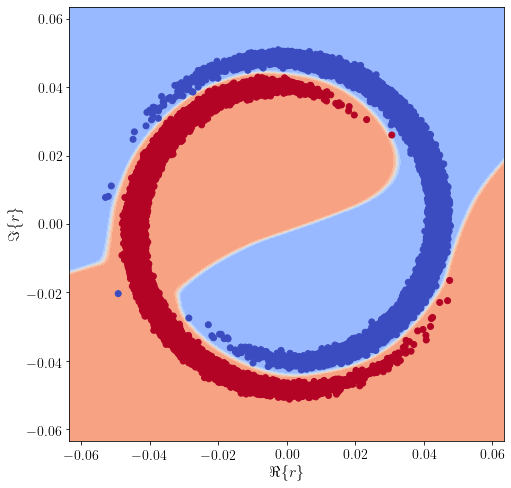

In [30]:
plt.figure(figsize=(8,8))
plt.contourf(mgx,mgy,decision_region_evolution[-1].reshape(mgy.shape).T,cmap='coolwarm',vmin=0.3,vmax=0.695)
plt.scatter(X_valid[:,0].cpu()*ext_max, X_valid[:,1].cpu() * ext_max, c=y_valid, cmap='coolwarm')
print(Pin)
plt.axis('scaled')
plt.xlabel(r'$\Re\{r\}$',fontsize=16)
plt.ylabel(r'$\Im\{r\}$',fontsize=16)
#plt.title(title,fontsize=16)
#plt.savefig('after_optimization.pdf',bbox_inches='tight')